# Facial Emotion Detection

# 1. Imports

In [1]:
# importing other dependencies
import numpy as np
import pandas as pd
# importing PyTorch
import torch
# importing torch.nn Module
import torch.nn as nn
# to load the activation functions
import torch.nn.functional as F
# importing Dataset, DataLoader
from torch.utils.data import Dataset, DataLoader, TensorDataset
# create datasets using `ImageFolder`
from torchvision.datasets import ImageFolder
# import compose and other transformations
from torchvision.transforms import Compose, RandomResizedCrop, RandomHorizontalFlip, ToTensor, Resize, CenterCrop
# plotting
import matplotlib.pyplot as plt


# for file paths
import os
# for time
import time
# for copying
import copy

In [2]:
# checks whether MPS is available
print(torch.backends.mps.is_available())

# this ensures that the current current PyTorch installation was built with MPS activated.
print(torch.backends.mps.is_built())

# setting the device to "mps" instead of default "cpu"
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

# checks whether CUDA is available
# print(torch.cuda.is_available())

# setting the device to "cuda" instead of default "cpu"
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# setting the device to "cpu"
# device = torch.device("cpu")

True
True


In [3]:
# check the device
device

device(type='mps')

# 2. Preparing Data

We use custom facial expression Kaggle dataset available at [this link](http://www.kaggle.com/dataset/de270025c781ba47a3a6d774a0d670452bfb4dc9d2d6b13740cdb0c17aa7bf2b).

Each image is a `48 x 48`, 3 channel image. We first convert it to single channel grayscale and process it accordingly.

In [4]:
from torchvision.transforms import Compose, RandomResizedCrop, RandomHorizontalFlip, Resize, CenterCrop, ToTensor, Normalize, Grayscale, RandomRotation

mean = np.array([0.5, 0.5, 0.5])
std = np.array([0.25, 0.25, 0.25])

data_transforms = {
    # train transform
    'train': Compose([
        RandomHorizontalFlip(),
        # 0.5 prob of rotating left/right by 30 deg
        RandomRotation(degrees=30),
        ToTensor(),
        Normalize(mean, std)
    ]),
    # test transform
    'test': Compose([
        ToTensor(),
        Normalize(mean, std)
    ])
}

In [5]:
data_dir = os.path.join('data','face_exp_data')
data_dir

'data/face_exp_data'

In [6]:
# some hyper-parameters
batch_size = 128
num_epochs = 32

In [7]:
# create datasets using `ImageFolder`

from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

image_datasets = {x:ImageFolder(root= os.path.join(data_dir, x), transform=data_transforms[x])
                for x in ['train', 'test']}

image_dataloaders = {'train':DataLoader(
                        dataset=image_datasets['train'],
                        batch_size=batch_size,
                        shuffle=True,
                    ),
                     'test':DataLoader(
                        dataset=image_datasets['test'],
                        batch_size=len(image_datasets['test']),
                        shuffle=True,
                    )}

data_sizes = {x:len(image_datasets[x])
                for x in ['train', 'test']}

class_names = image_datasets['train'].classes
print("Class Names:", class_names)

Class Names: ['Angry', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise']


Let's analyse the data.

In [8]:
# extracting the test dataset
X_test, y_test = next(iter(image_dataloaders['test']))
# move the data to GPU
X_test, y_test = X_test.to(device), y_test.to(device)
# print the shape
print(X_test.shape, y_test.shape)

torch.Size([3589, 3, 48, 48]) torch.Size([3589])


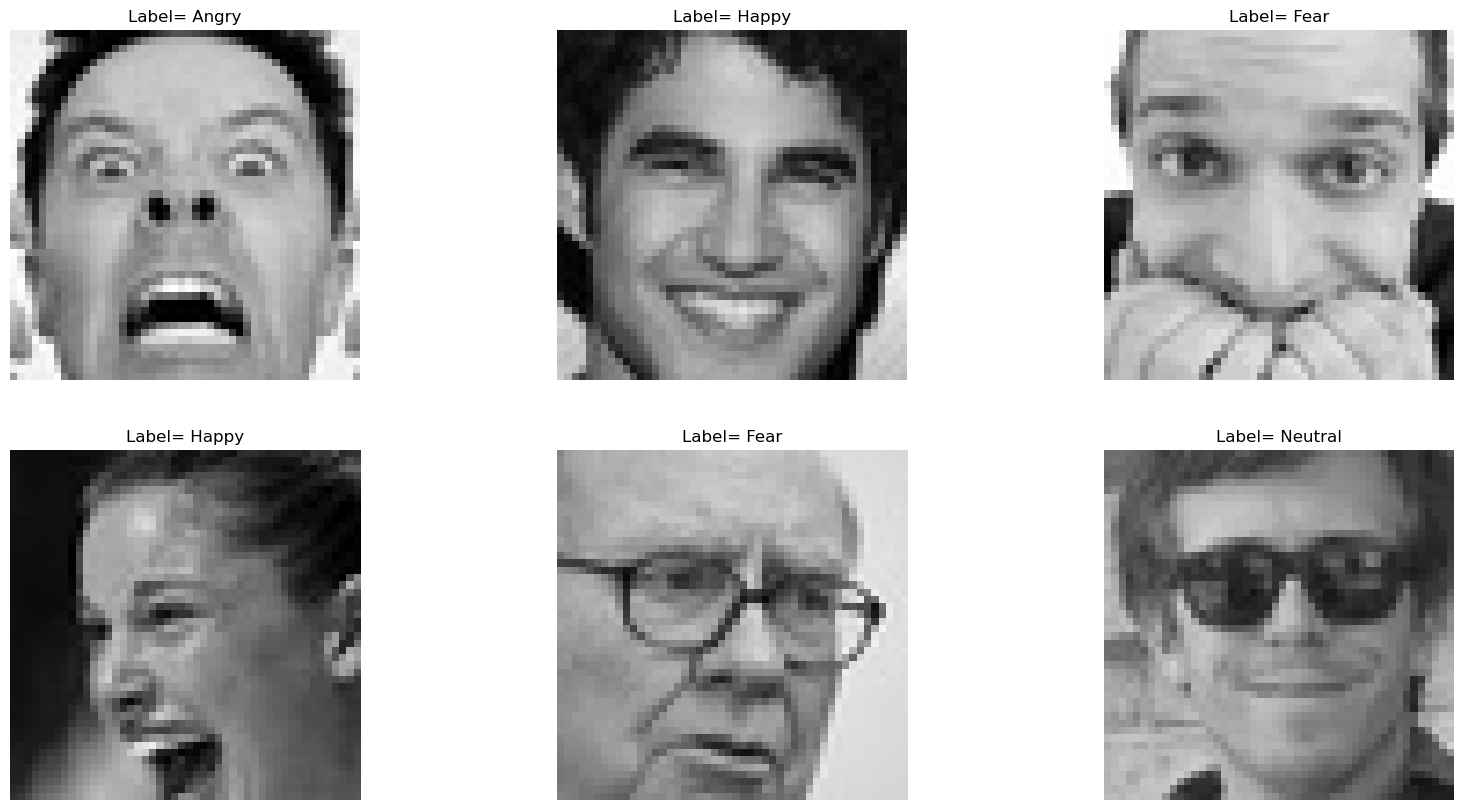

In [11]:
plt.figure(figsize=(20,10))
for i in range(6):
    plt.subplot(2, 3, i+1)
    # copy the image back to cpu to reshape
    img = X_test[i].cpu()
    # we have multi-channel image
    # pre-precoss the image before printing
    img = np.transpose(img, (1,2,0))
    img = img * std + mean
    img = np.clip(img, 0, 1)
    
    plt.imshow(img)
    plt.title("Label= " + class_names[y_test[i]])
    plt.grid(False)
    plt.axis(False)
plt.show()

# 3. Models

## 3.1 Model-1: Custom

In [12]:
# defining the repeating basic block
# each basic block has 2 convolutional layers
# first convolutional layer is followed by Batch Normalization and ReLU
# second convolutional layer is only followed by Batch Normalization
# we apply a second ReLU after adding the residue with identity

class ResBlock18(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResBlock18, self).__init__()

        # input = i,n,n
        # conv-layer-1
        self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        # batch normalization layer
        self.bn1 = nn.BatchNorm2d(num_features=out_channels)
        # relu
        self.relu = nn.ReLU(inplace=True)

        # input = i,n,n
        # conv-layer-2
        self.conv2 = nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        # batch normalization layer
        self.bn2 = nn.BatchNorm2d(num_features=out_channels)

        # if input dim != output dim (happens when stride != 1) we downsample the input using 1x1 conv to the same dim as output
        if stride != 1 or in_channels != out_channels:
            self.downsample = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )
        else:
            self.downsample = None
    
    def forward(self, X):
        # store/downsample identity
        idn = X
        # input dim != output dim
        if self.downsample is not None:
            idn = self.downsample(idn)
        
        # evaluate residue
        # layer-1
        res = self.relu(self.bn1(self.conv1(X)))
        # layer-2
        res = self.bn2(self.conv2(res))

        
        # add the residue and identity
        out = idn + res
        
        # relu layer
        out = self.relu(out)

        return out


# defining full ResNet-18

class ResNet18(nn.Module):
    def __init__(self, image_channels, num_classes):
        super(ResNet18, self).__init__()

        # Initial Layers: define the layers before the Residual Layers
        
        # Conv2d->BN->ReLU->Max-Pooling
        # changes the no. of channels to 64
        self.in_channels = 64
        
        self.conv1 = nn.Conv2d(in_channels=image_channels, out_channels=self.in_channels, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(num_features=self.in_channels)
        self.relu = nn.ReLU(inplace=True)

        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # Residual Layers
        
        # for ResNet18 we have 4 types of Residual Blocks being repeated twice each [2,2,2,2]
        
        self.layer1 = self._make_layer(in_channels=64, out_channels=64, stride=1)

        self.layer2 = self._make_layer(in_channels=64, out_channels=128, stride=2)

        self.layer3 = self._make_layer(in_channels=128, out_channels=256, stride=2)

        self.layer4 = self._make_layer(in_channels=256, out_channels=512, stride=2)

        # Final Layers: define the layers after the Residual Layers

        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(512, num_classes)
    
    def _make_layer(self, in_channels, out_channels, stride):
        return nn.Sequential(
            ResBlock18(in_channels=in_channels, out_channels=out_channels, stride=stride),
            ResBlock18(in_channels=out_channels, out_channels=out_channels)
        )
    
    
    def forward(self, X):
        
        # Initial Layers
        out = self.maxpool(self.relu(self.bn1(self.conv1(X))))

        # Residual Layers
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)

        # Final Layers
        out = self.avgpool(out)
        # reshape
        out = out.view(out.shape[0], -1)
        out = self.fc(out)

        return out

Let's initialize the model and test the result of the test dataset.

In [13]:
# define the model
model1 = ResNet18(image_channels=3, num_classes=len(class_names))
# 3 channel image, 7 classes

# add model to GPU
model1 = model1.to(device)

In [14]:
# we also check the initial accuracy on the test data before training

from sklearn.metrics import accuracy_score

with torch.no_grad():
    # this gives the sigmoid outputx
    y_test_pred = model1(X_test)
    # this gives the index of the max column per row
    _ , y_test_hat = torch.max(y_test_pred, dim=1)
    # push the matrices back to cpu from gpu
    y_test_hat_cpu = y_test_hat.cpu()
    y_test_cpu = y_test.cpu()
    print("Initial Accuracy on test data:", accuracy_score(y_test_cpu, y_test_hat_cpu))

Initial Accuracy on test data: 0.13708553914739482


## 3.2 Model-2: Transfer Learning

In [15]:
from torchvision import models

model2 = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)

# freeze all the layers except the final FC Layer
'''
for params in model2.parameters():
    params.requires_grad=False
'''

# parameters of newly constructed modules have `required_grad=True` by default
# extract the input features taken in by the last FC layer
fc_inp_size = model2.fc.in_features
# reset the fc layer
model2.fc = nn.Linear(fc_inp_size, len(class_names))

# add model to GPU
model2 = model2.to(device)

In [16]:
# we also check the initial accuracy on the test data before training

from sklearn.metrics import accuracy_score

with torch.no_grad():
    # this gives the sigmoid outputx
    y_test_pred = model2(X_test)
    # this gives the index of the max column per row
    _ , y_test_hat = torch.max(y_test_pred, dim=1)
    # push the matrices back to cpu from gpu
    y_test_hat_cpu = y_test_hat.cpu()
    y_test_cpu = y_test.cpu()
    print("Initial Accuracy on test data:", accuracy_score(y_test_cpu, y_test_hat_cpu))

Initial Accuracy on test data: 0.18974644747840624


# 4. Training

In [17]:
from sklearn.metrics import accuracy_score

def train_model(model, criterion, optimizer, scheduler=None, grad_clip=None, num_epochs=20):
    # begin start time to record time-elapsed
    # since = time.time()

    # to return the model with best accuracy
    # variable to store the best model parameters
    best_model_params = copy.deepcopy(model.state_dict())
    # variable to store the best accuracy
    best_acc = 0.0
    # update tolerance
    tolerance = 0.0

    # start training epochs
    for epoch in range(num_epochs):

        # each epoch has a training and test phase
        for phase in ['train', 'test']:
            if phase=='train':
                model.train() # set model to training mode
            else:
                model.eval() # set model to evaluate mode
            
            # iterate over data
            for batch in image_dataloaders[phase]:
                # extract features and labels
                X,y = batch
                # adding to GPU
                X,y = X.to(device), y.to(device)

                # forward
                # track grad iff phase == train
                with torch.set_grad_enabled(phase=='train'):
                    # compute prediction
                    y_pred = model(X)

                    # loss + backward + optimize iff phase = 'train'
                    if phase=='train':
                        # compute loss
                        loss = criterion(y_pred, y)
                        # compute grads
                        loss.backward()
                        # update weights
                        optimizer.step()
                        # zero-gradients after updating
                        optimizer.zero_grad()
                
            # learning scheduler step iff phase == 'train'
            if scheduler and phase=='train':
                # update learning rate
                scheduler.step()
            
            # gradient clipping iff phase == 'train
            if grad_clip and phase=='train':
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            
            # check accuracy on test set iff phase == 'test'
            if phase=='test':
                _, y_hat = torch.max(y_pred, dim=1)
                epoch_acc = accuracy_score(y.cpu(), y_hat.cpu())

        # update best_model and best accuracy after the epoch
        if epoch_acc >= best_acc + tolerance:
            best_acc = epoch_acc
            best_model_params = copy.deepcopy(model.state_dict())
        
        # print epoch info
        print('-----------------------------------------')
        print('Epoch: {}/{}'.format(epoch+1, num_epochs))
        print('Best Test Acc: {:2f}'.format(best_acc))
        # to keep track of time
        '''
        time_elapsed = time.time() - since
        print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
        '''
    

    # post training, load the best_model parameters and output the model

    # load best model weights
    model.load_state_dict(best_model_params)
    return model


In [18]:
# some hyper-parameters
batch_size = 128
num_epochs = 32
max_lr = 0.008
grad_clip = 0.1
weight_decay = 0.0001

## 4.1 Training Model-1

In [19]:
# define parameters for training

# define loss
criterion = nn.CrossEntropyLoss()

# define optimizer
optimizer = torch.optim.Adam(
    params=model1.parameters(),
    lr = max_lr,
    weight_decay=weight_decay
)

# step Learning Rate scheduler
lr_scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer=optimizer,
    max_lr=max_lr,
    epochs=num_epochs,
    steps_per_epoch=len(image_dataloaders['train'])
)

model1 = train_model(
    model=model1,
    criterion=criterion,
    optimizer=optimizer,
    #scheduler=lr_scheduler,
    grad_clip=grad_clip,
    num_epochs=num_epochs
)

-----------------------------------------
Epoch: 1/32
Best Test Acc: 0.383951
-----------------------------------------
Epoch: 2/32
Best Test Acc: 0.425188
-----------------------------------------
Epoch: 3/32
Best Test Acc: 0.458345
-----------------------------------------
Epoch: 4/32
Best Test Acc: 0.461131
-----------------------------------------
Epoch: 5/32
Best Test Acc: 0.484536
-----------------------------------------
Epoch: 6/32
Best Test Acc: 0.487322
-----------------------------------------
Epoch: 7/32
Best Test Acc: 0.499303
-----------------------------------------
Epoch: 8/32
Best Test Acc: 0.499303
-----------------------------------------
Epoch: 9/32
Best Test Acc: 0.499303
-----------------------------------------
Epoch: 10/32
Best Test Acc: 0.501532
-----------------------------------------
Epoch: 11/32
Best Test Acc: 0.501532
-----------------------------------------
Epoch: 12/32
Best Test Acc: 0.511284
-----------------------------------------
Epoch: 13/32
Best T

In [20]:
# we also check the final accuracy on the test data after training

from sklearn.metrics import accuracy_score

with torch.no_grad():
    # this gives the sigmoid outputx
    y_test_pred = model1(X_test)
    # this gives the index of the max column per row
    _ , y_test_hat = torch.max(y_test_pred, dim=1)
    # push the matrices back to cpu from gpu
    y_test_hat_cpu = y_test_hat.cpu()
    y_test_cpu = y_test.cpu()
    print("Final Accuracy on test data:", accuracy_score(y_test_cpu, y_test_hat_cpu))

Final Accuracy on test data: 0.5522429646140986


In [21]:
model1_save_path = os.path.join('models','ResNet18-32E.pth')
model1_save_path

'models/ResNet18-32E.pth'

In [22]:
torch.save(model1, model1_save_path)

## 4.2 Training Model-2

In [23]:
# define parameters for training

# define loss
criterion = nn.CrossEntropyLoss()

# define optimizer
optimizer = torch.optim.Adam(
    params=model2.parameters(),
    lr = max_lr,
    weight_decay=weight_decay
)

# step Learning Rate scheduler
lr_scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer=optimizer,
    max_lr=max_lr,
    epochs=num_epochs,
    steps_per_epoch=len(image_dataloaders['train'])
)

model2 = train_model(
    model=model2,
    criterion=criterion,
    optimizer=optimizer,
    #scheduler=lr_scheduler,
    #grad_clip=grad_clip,
    num_epochs=num_epochs
)

-----------------------------------------
Epoch: 1/32
Best Test Acc: 0.465589
-----------------------------------------
Epoch: 2/32
Best Test Acc: 0.498468
-----------------------------------------
Epoch: 3/32
Best Test Acc: 0.498468
-----------------------------------------
Epoch: 4/32
Best Test Acc: 0.519365
-----------------------------------------
Epoch: 5/32
Best Test Acc: 0.524659
-----------------------------------------
Epoch: 6/32
Best Test Acc: 0.535247
-----------------------------------------
Epoch: 7/32
Best Test Acc: 0.535247
-----------------------------------------
Epoch: 8/32
Best Test Acc: 0.546392
-----------------------------------------
Epoch: 9/32
Best Test Acc: 0.551686
-----------------------------------------
Epoch: 10/32
Best Test Acc: 0.551686
-----------------------------------------
Epoch: 11/32
Best Test Acc: 0.551686
-----------------------------------------
Epoch: 12/32
Best Test Acc: 0.551686
-----------------------------------------
Epoch: 13/32
Best T

In [24]:
# we also check the final accuracy on the test data after training

from sklearn.metrics import accuracy_score

with torch.no_grad():
    # this gives the sigmoid outputx
    y_test_pred = model2(X_test)
    # this gives the index of the max column per row
    _ , y_test_hat = torch.max(y_test_pred, dim=1)
    # push the matrices back to cpu from gpu
    y_test_hat_cpu = y_test_hat.cpu()
    y_test_cpu = y_test.cpu()
    print("Final Accuracy on test data:", accuracy_score(y_test_cpu, y_test_hat_cpu))

Final Accuracy on test data: 0.5706324881582614


In [25]:
model2_save_path = os.path.join('models','ResNet18PT-32E.pth')
model2_save_path

'models/ResNet18PT-32E.pth'

In [26]:
torch.save(model2, model2_save_path)

In [27]:
model_main = torch.load(model2_save_path)
model_main.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

# 5. Visualization

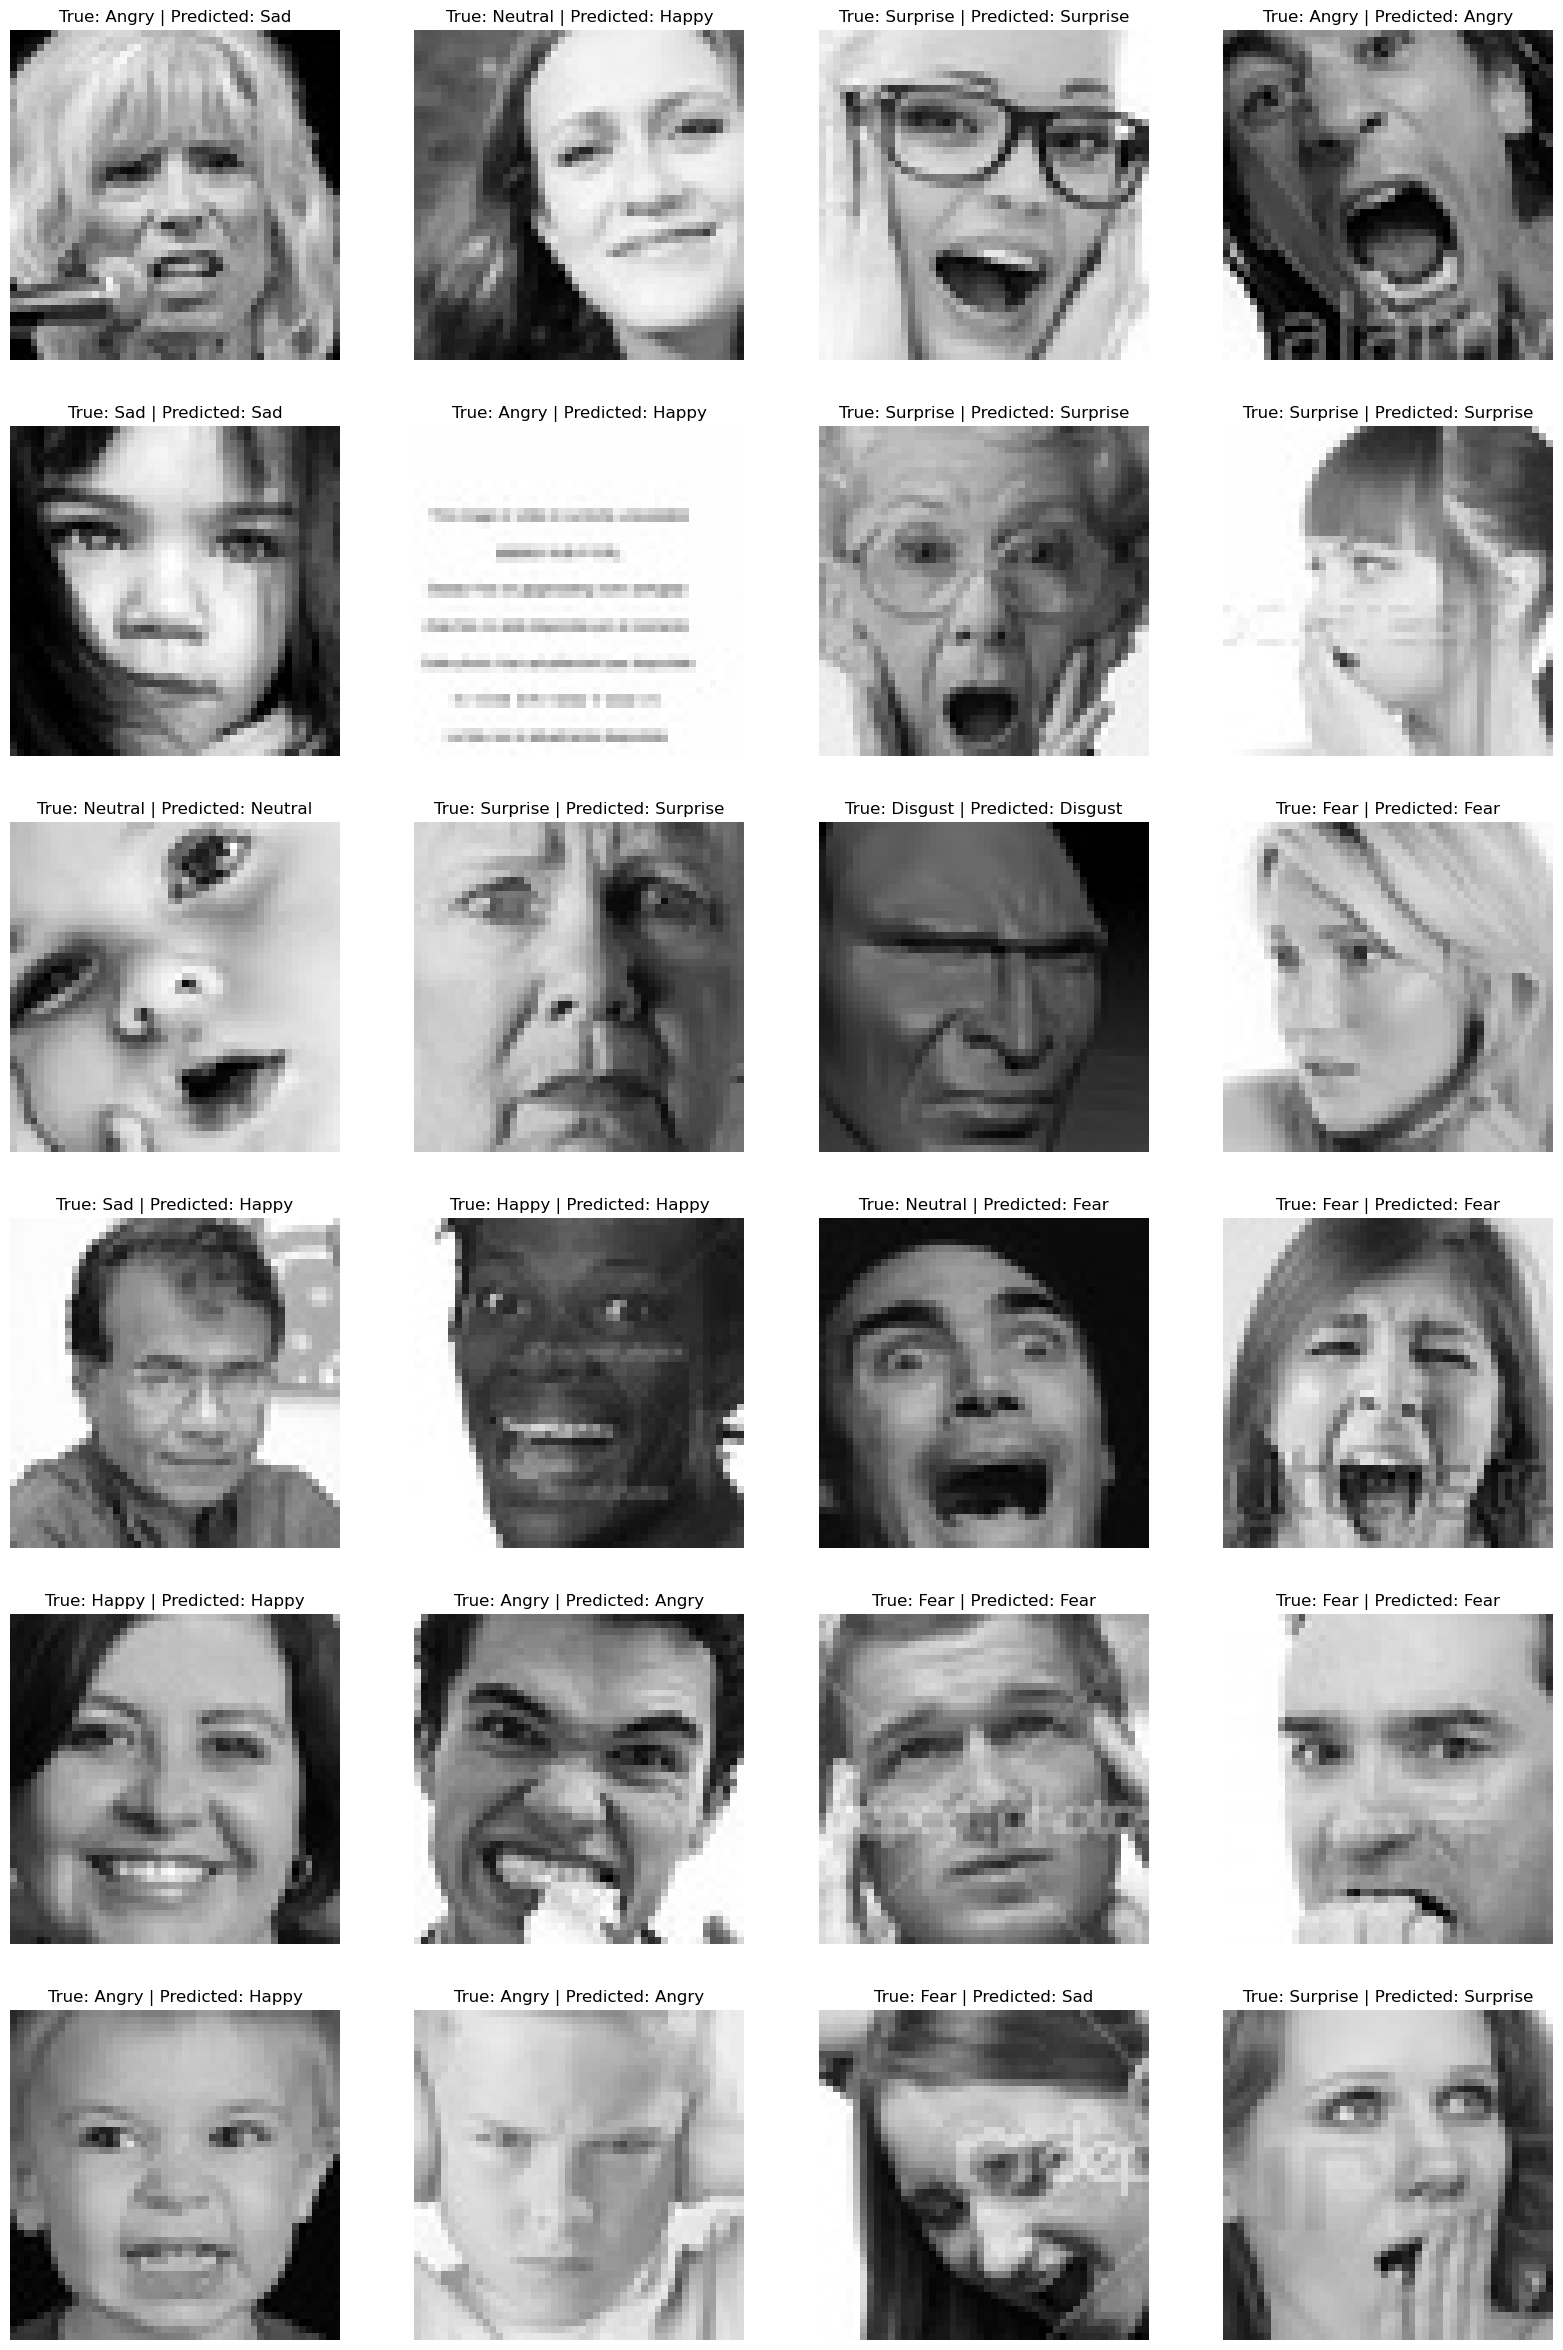

In [28]:
with torch.no_grad():
    # this gives the sigmoid output
    y_test_pred = model_main(X_test)
    # this gives the index of the max column per row
    _ , y_test_hat = torch.max(y_test_pred, dim=1)


test_idx = np.random.randint(X_test.shape[0] ,size=24)

plt.figure(figsize=(20,30))
for i in range(24):
    plt.subplot(6, 4, i+1)
    # copy the image back to cpu to reshape
    img = X_test[test_idx[i]].cpu()
    # we have multi-channel image
    # pre-precoss the image before printing
    img = np.transpose(img, (1,2,0))
    img = img * std + mean
    img = np.clip(img, 0, 1)
    
    plt.imshow(img)
    plt.title("True: " + class_names[y_test[test_idx[i]]] + " | Predicted: " + class_names[y_test_hat[test_idx[i]]])
    plt.grid(False)
    plt.axis(False)
plt.show()

# 6. Realtime Rendering

We use **Haar Cascade Classifier** to detect faces.

In [29]:
cascade_classifier_path = os.path.join('data', 'haarcascade_frontalface_default.xml')

In [30]:
import cv2
from torchvision.transforms import ToTensor

# transform to convert to pytorch Tensor
transform = ToTensor()

def emotion_extractor(model, frame_gray, x, y, w, h):
    # crop the face out of image
    img = frame_gray[y-70:y+h+10, x:x+w]

    # convert the grayscale image to color
    img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)

    # resize this to 48,48,3 dim image
    resized_dim = X_test.shape[-2], X_test.shape[-1]
    img = cv2.resize(img, resized_dim)

    # convert to pytorch tensor
    img = transform(img)

    # convert c,48,48 -> 1,c,48,48
    img = img.unsqueeze(0)

    # add tensor to GPU
    img = img.to(device)

    # extract emotion
    with torch.no_grad():
        _, pred = torch.max(model_main(img), dim=1)
        emotion = class_names[pred[0]]

    return emotion

In [32]:
import cv2

# load the cascade classifier for face detection
face_cascade = cv2.CascadeClassifier(cascade_classifier_path)

# class_index
class_index = {'Angry':0, 'Disgust':1, 'Fear':2, 'Happy':3, 'Neutral':4, 'Sad':5, 'Surprise':6}
# store values of last 'moving_window_size' no. of frames to smoothen
moving_window_size = 24
# defaut value 'neutral': 4
moving_window_pred = class_index['Neutral']*np.ones(moving_window_size, dtype=np.int64)

# establish connection to the webcam
cap = cv2.VideoCapture(0)

# loop through every frame, while the webcam connection is open
while cap.isOpened():
    # capture frame
    ret, frame = cap.read()

    # convert to grayscale
    frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # detect faces in the frame
    faces = face_cascade.detectMultiScale(frame_gray, scaleFactor=1.1, minNeighbors=5)

    
    if len(faces) == 1:
        x, y, w, h = faces[0]

        # extract current emotion
        current_emotion = emotion_extractor(model_main, frame_gray, x, y, w, h)

        # shift the moving_window_pred vector, 1 place to the left, keeping the last element the same
        moving_window_pred = np.roll(moving_window_pred, -1)
        # update the last entry
        moving_window_pred[-1] = class_index[current_emotion]

        # smoothed emotion by voting
        counts = np.bincount(moving_window_pred)
        mode_emotion = class_names[np.argmax(counts)]

        # draw a rectangle around the face
        cv2.rectangle(frame_gray, (x,y-70), (x+w, y+h+10), (255, 0, 0), 2)
        # put mode emotion in a text-box
        #cv2.putText(frame_gray, text="Emotion: "+mode_emotion, org=(50,50), fontFace=cv2.FONT_HERSHEY_PLAIN, fontScale=3, color=(0,0,256), thickness=3)

        # put current emotion in a text-box
        cv2.putText(frame_gray, text="Emotion: "+current_emotion, org=(50,50), fontFace=cv2.FONT_HERSHEY_PLAIN, fontScale=3, color=(0,0,256), thickness=3)
        
        # show live feed (image)
        cv2.imshow('Live Webcam Feed' ,frame_gray)
    

    # exit condition / breaking out of the loop
    k = cv2.waitKey(1) # this checks whether or not we are hitting any key and accepts the stroke into the variable 'k'
    # keep this 25ms for smooth playback
    if k == ord('q'): # if we press 'q', we will exit (break out of the loop)
        break

# Releasing the video capture device
cap.release()

# Closing all the windows
cv2.destroyAllWindows()
cv2.waitKey(1)

1   HIToolbox                           0x00000001b6d4ed4c _ZN15MenuBarInstance21IsAutoShowHideAllowedEv + 284
2   HIToolbox                           0x00000001b6c28230 _ZN15MenuBarInstance24UpdateAutoShowVisibilityE5Pointh + 40
3   HIToolbox                           0x00000001b6b9530c _ZN15MenuBarInstance16ForEachMenuBarDoEU13block_pointerFvPS_E + 72
4   HIToolbox                           0x00000001b6c288a0 _ZN15MenuBarInstance20AutoShowHideObserverEjP14OpaqueEventRefPv + 216
5   HIToolbox                           0x00000001b6b8bcd0 _NotifyEventLoopObservers + 176
6   HIToolbox                           0x00000001b6bbfbb0 PostEventToQueueInternal + 696
7   HIToolbox                           0x00000001b6bc1340 _ZL29CreateAndPostEventWithCGEventP9__CGEventjhP17__CFMachPortBoost + 460
8   HIToolbox                           0x00000001b6bc0c44 _ZL38PullEventsFromWindowServerOnConnectionjhP17__CFMachPortBoost + 296
9   HIToolbox                           0x00000001b6bc0ae0 _ZL14Messag

error: OpenCV(4.6.0) /Users/runner/miniforge3/conda-bld/libopencv_1671406937350/work/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'


: 

In [ ]:
%%time